# Ahşap Anomali Tespiti - Veri Önişleme (Jupyter Notebook)

Bu notebook, `data_preprocessing.py` scriptindeki adımları interaktif bir şekilde uygular.

**Adımlar:**
1. Gerekli kütüphaneleri ve yolları tanımlama
2. Veri setini bir Pandas DataFrame'e yükleme
3. Görüntü önişleme fonksiyonlarını tanımlama
4. Örnek bir görüntü üzerinde önişleme adımlarını test etme ve görselleştirme
5. Tüm veri setini işleyip yeni bir klasöre kaydetme

In [11]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import shutil
from skimage import exposure

# tqdm'un pandas ile entegrasyonu için
tqdm.pandas()

## 1. Dataset Yollarını Tanımlama

Orijinal veri setinin ve önişlenmiş verilerin kaydedileceği klasör yollarını belirliyoruz.

In [12]:
# Orijinal dataset yolları
DATASET_ROOT = "dataset/wood"
TRAIN_GOOD_PATH = os.path.join(DATASET_ROOT, "train", "good")
TEST_GOOD_PATH = os.path.join(DATASET_ROOT, "test", "good")
TEST_DEFECT_PATH = os.path.join(DATASET_ROOT, "test", "defect")

# Önişlenmiş verilerin kaydedileceği ana klasör
PREPROCESSED_ROOT = "dataset/wood_preprocessed_notebook"

print(f"Orijinal Dataset Kök Dizini: {DATASET_ROOT}")
print(f"Önişlenmiş Veri Kök Dizini: {PREPROCESSED_ROOT}")

Orijinal Dataset Kök Dizini: dataset/wood
Önişlenmiş Veri Kök Dizini: dataset/wood_preprocessed_notebook


## 2. Veriyi DataFrame Olarak Yükleme

Tüm görüntülerin yollarını, etiketlerini (`good`/`defect`) ve setlerini (`train`/`test`) içeren bir Pandas DataFrame oluşturalım. Bu, veri üzerinde çalışmayı kolaylaştırır.

In [14]:
def create_dataset_df(root_path):
    """Veri seti yollarını tarayarak bir DataFrame oluşturur."""
    image_paths = []
    
    # Path objesi ile tüm .bmp dosyalarını bul
    for path in Path(root_path).rglob('*.bmp'):
        parts = path.parts
        # Klasör yapısına göre etiketleri ve setleri çıkar
        # dataset/wood/test/defect/image.bmp -> ('...','test','defect','image.bmp')
        dataset_type = parts[-3]  # train veya test
        label = parts[-2]         # good veya defect
        filename = parts[-1]      # dosya adı
        
        image_paths.append({
            'filepath': str(path),
            'type': dataset_type,
            'label': label,
            'filename': filename
        })
        
    return pd.DataFrame(image_paths)

# DataFrame'i oluşturalım
df = create_dataset_df(DATASET_ROOT)

print("DataFrame başarıyla oluşturuldu!")
print(f"Toplam görüntü sayısı: {len(df)}")

# DataFrame'in ilk 5 satırını ve bilgilerini göster
display(df.head())
print("\nDataFrame Bilgileri:")
df.info()

DataFrame başarıyla oluşturuldu!
Toplam görüntü sayısı: 136


,filepath,type,label,filename
0,dataset\wood\test\defect\Basler_r2L4096-14gc__...,test,defect,Basler_r2L4096-14gc__40653549__20251009_075252...
1,dataset\wood\test\defect\Basler_r2L4096-14gc__...,test,defect,Basler_r2L4096-14gc__40653549__20251009_075252...
2,dataset\wood\test\defect\Basler_r2L4096-14gc__...,test,defect,Basler_r2L4096-14gc__40653549__20251009_075356...
3,dataset\wood\test\defect\Basler_r2L4096-14gc__...,test,defect,Basler_r2L4096-14gc__40653549__20251009_075356...
4,dataset\wood\test\defect\Basler_r2L4096-14gc__...,test,defect,Basler_r2L4096-14gc__40653549__20251009_075942...



DataFrame Bilgileri:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  136 non-null    object
 1   type      136 non-null    object
 2   label     136 non-null    object
 3   filename  136 non-null    object
dtypes: object(4)
memory usage: 4.4+ KB


## 3. Görüntü Önişleme Sınıfı ve Fonksiyonları

`data_preprocessing.py` scriptindeki `ImagePreprocessor` sınıfını buraya taşıyoruz. Bu sınıf, tüm önişleme mantığını içerir.

In [15]:
class ImagePreprocessor:
    """Görüntü önişleme sınıfı"""
    
    def __init__(self, target_size=(256, 256), apply_crop=True):
        self.target_size = target_size
        self.apply_crop = apply_crop
        
    def load_image(self, image_path):
        image = cv2.imread(str(image_path))
        if image is not None:
            return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return None
    
    def crop_with_canny(self, image, threshold=10):
        """Crops borders using Canny edge detection."""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        coords = np.column_stack(np.where(edges > 0))
        if len(coords) == 0:
            return image
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        margin = 10
        h, w = image.shape[:2]
        y_min = max(0, y_min - margin)
        x_min = max(0, x_min - margin)
        y_max = min(h, y_max + margin)
        x_max = min(w, x_max + margin)
        return image[y_min:y_max, x_min:x_max]

    def crop_with_otsu(self, image):
        """Crops the image using Otsu's thresholding to find the main object."""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Gürültüyü azaltmak için blur uygulama
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # Otsu's thresholding (THRESH_BINARY_INV yerine THRESH_BINARY kullanarak)
        # Bu, ahşabın arka plandan daha açık renkli olduğu varsayımına dayanır.
        _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if not contours:
            return image # Return original if no contours found
            
        # Find the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Get bounding box
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Add a small margin
        margin = 10
        h_img, w_img = image.shape[:2]
        x_start = max(0, x - margin)
        y_start = max(0, y - margin)
        x_end = min(w_img, x + w + margin)
        y_end = min(h_img, y + h + margin)
        
        return image[y_start:y_end, x_start:x_end]
    
    def apply_gabor(self, image, ksize=(31, 31), sigma=5.0, theta=np.pi/4, lambd=10.0, gamma=0.5):
        """Applies a Gabor filter to highlight texture."""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        kernel = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)
        gabor_response = cv2.filter2D(gray, cv2.CV_8U, kernel)
        return cv2.cvtColor(gabor_response, cv2.COLOR_GRAY2RGB)

    def denoise(self, image, method='bilateral'):
        if method == 'bilateral':
            return cv2.bilateralFilter(image, 9, 75, 75)
        elif method == 'gaussian':
            return cv2.GaussianBlur(image, (5, 5), 0)
        elif method == 'median':
            return cv2.medianBlur(image, 5)
        elif method == 'nlm':
            return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
        return image
    
    def enhance_contrast(self, image, method='clahe'):
        if method == 'clahe':
            lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            l_clahe = clahe.apply(l)
            enhanced_lab = cv2.merge([l_clahe, a, b])
            return cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)
        elif method == 'histogram_eq':
            ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            ycrcb[:, :, 0] = cv2.equalizeHist(ycrcb[:, :, 0])
            return cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)
        elif method == 'adaptive':
            return exposure.equalize_adapthist(image, clip_limit=0.03)
        return image
    
    def sharpen(self, image, strength=1.0):
        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) * strength
        return cv2.filter2D(image, -1, kernel)
    
    def normalize_image(self, image, method='minmax'):
        image_float = image.astype(np.float32)
        if method == 'minmax':
            normalized = (image_float - image_float.min()) / (image_float.max() - image_float.min() + 1e-8)
        elif method == 'zscore':
            mean = image_float.mean()
            std = image_float.std() + 1e-8
            normalized = (image_float - mean) / std
            normalized = (normalized - normalized.min()) / (normalized.max() - normalized.min() + 1e-8)
        elif method == 'robust':
            p2, p98 = np.percentile(image_float, (2, 98))
            normalized = np.clip((image_float - p2) / (p98 - p2 + 1e-8), 0, 1)
        return (normalized * 255).astype(np.uint8)
    
    def resize_image(self, image, target_size=None):
        if target_size is None:
            target_size = self.target_size
        return cv2.resize(image, target_size, interpolation=cv2.INTER_LANCZOS4)
    
    def preprocess_pipeline(self, image, config=None):
        if config is None:
            config = {
                'crop_method': 'canny', # 'canny', 'otsu', or None
                'denoise': 'bilateral',
                'contrast': 'clahe',
                'sharpen': True,
                'sharpen_strength': 0.5,
                'normalize': 'minmax',
                'resize': True
            }
        
        processed = image.copy()
        
        crop_method = config.get('crop_method')
        if crop_method == 'canny':
            processed = self.crop_with_canny(processed)
        elif crop_method == 'otsu':
            processed = self.crop_with_otsu(processed)

        if config.get('denoise'):
            processed = self.denoise(processed, method=config['denoise'])
        if config.get('contrast'):
            processed = self.enhance_contrast(processed, method=config['contrast'])
        if config.get('sharpen', False):
            strength = config.get('sharpen_strength', 0.5)
            processed = self.sharpen(processed, strength=strength)
        if config.get('normalize'):
            processed = self.normalize_image(processed, method=config['normalize'])
        if config.get('resize', True):
            processed = self.resize_image(processed)
        
        return processed

print("ImagePreprocessor sınıfı, Gabor filtresi ile güncellendi.")

ImagePreprocessor sınıfı, Gabor filtresi ile güncellendi.


## 4. Örnek Görüntü Üzerinde Test ve Görselleştirme (Otsu Kırpma)

Bir örnek görüntü seçip, "Balanced" (dengeli) konfigürasyon ile önişleme adımlarını uygulayalım ve sonucu görelim.

Test için seçilen görüntü: dataset\wood\train\good\Basler_r2L4096-14gc__40653549__20251009_075356218_0228.bmp


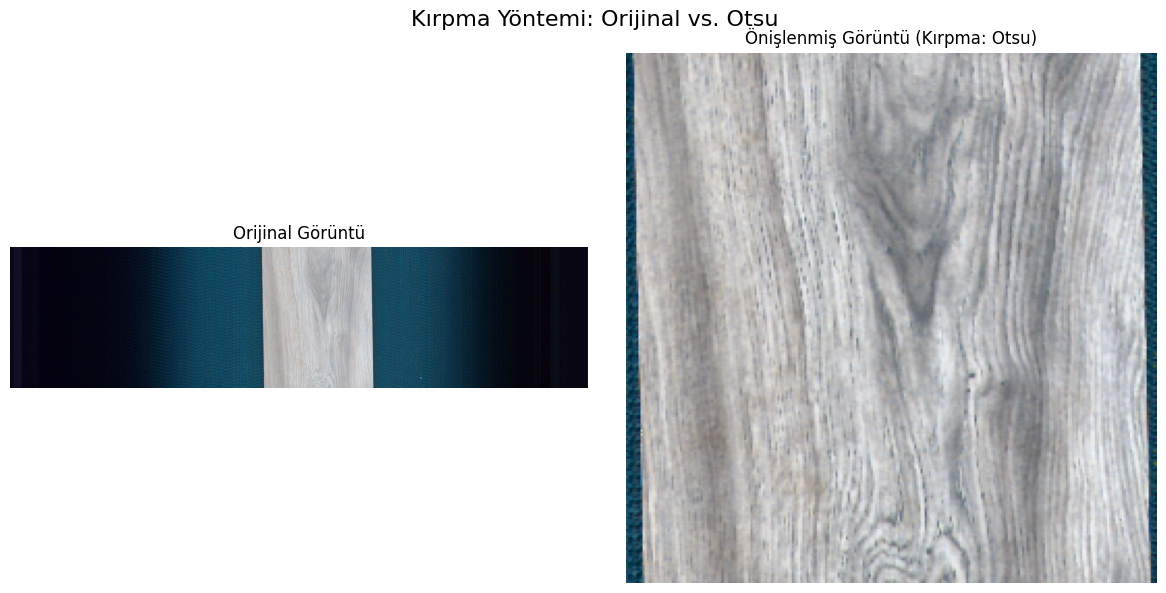

In [17]:
# Preprocessor'ı oluşturalım
preprocessor = ImagePreprocessor(target_size=(256, 256))

# Örnek bir görüntü seçelim (eğitim setinden)
sample_row = df[df['type'] == 'train'].sample(1).iloc[0]
sample_path = sample_row['filepath']

print(f"Test için seçilen görüntü: {sample_path}")

# Görüntüyü yükle
original_image = preprocessor.load_image(sample_path)

# Önişleme pipeline'ını Otsu kırpma ile uygula
otsu_config = {
    'crop_method': 'otsu',
    'denoise': 'bilateral',
    'contrast': 'clahe',
    # 'sharpen': True,
    # 'sharpen_strength': 0.5,
    'normalize': 'minmax',
    'resize': True
}
processed_image_otsu = preprocessor.preprocess_pipeline(original_image, config=otsu_config)

# Sonuçları görselleştir
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Kırpma Yöntemi: Orijinal vs. Otsu', fontsize=16)

axes[0].imshow(original_image)
axes[0].set_title('Orijinal Görüntü')
axes[0].axis('off')

axes[1].imshow(processed_image_otsu)
axes[1].set_title("Önişlenmiş Görüntü (Kırpma: Otsu)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
<VSCode.Cell id="6d521717" language="markdown">
## 4.1. Görüntü İyileştirme Tekniklerinin Karşılaştırılması (CLAHE vs. Gabor)

Bu bölümde, farklı görüntü iyileştirme tekniklerinin etkilerini görsel olarak karşılaştıracağız. Özellikle, kontrastı artıran **CLAHE** ve doku özelliklerini vurgulayan **Gabor filtresi** arasındaki farkları inceleyeceğiz.
</VSCode.Cell>


In [ ]:
# Örnek bir görüntü üzerinde iyileştirme tekniklerini test edelim
# Preprocessor'ı yeniden oluşturmaya gerek yok, yukarıdaki hücrede zaten var.
# sample_path da bir önceki hücreden geliyor.

print(f"İyileştirme testi için kullanılan görüntü: {sample_path}")

# Görüntüyü yükle
original_image = preprocessor.load_image(sample_path)
# Kırpma işlemi, iyileştirme öncesi odaklanmayı artırabilir
cropped_image = preprocessor.crop_with_otsu(original_image)

# CLAHE uygula
clahe_image = preprocessor.enhance_contrast(cropped_image.copy(), method='clahe')

# Gabor filtresi uygula (farklı yönelimler için birkaç örnek)
gabor_image_1 = preprocessor.apply_gabor(cropped_image.copy(), theta=np.pi/4) # 45 derece
gabor_image_2 = preprocessor.apply_gabor(cropped_image.copy(), theta=np.pi)   # 180 derece

# Sonuçları görselleştir
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Görüntü İyileştirme Teknikleri Karşılaştırması', fontsize=18)

axes[0, 0].imshow(original_image)
axes[0, 0].set_title('Orijinal Görüntü')
axes[0, 0].axis('off')

axes[0, 1].imshow(clahe_image)
axes[0, 1].set_title('CLAHE Uygulanmış')
axes[0, 1].axis('off')

axes[1, 0].imshow(gabor_image_1)
axes[1, 0].set_title('Gabor Filtresi (45°)')
axes[1, 0].axis('off')

axes[1, 1].imshow(gabor_image_2)
axes[1, 1].set_title('Gabor Filtresi (180°)')
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
</VSCode.Cell>


## 5. Tüm Veri Setini İşle ve Kaydet

Şimdi tüm DataFrame'i satır satır gezip her bir görüntüyü işleyeceğiz ve sonuçları `PREPROCESSED_ROOT` ile belirtilen yeni klasör yapısına kaydedeceğiz.

In [ ]:
def process_and_save(df, preprocessor, output_root, config):
    """DataFrame'deki tüm görüntüleri işler ve belirtilen klasöre kaydeder."""
    
    print(f"Çıktı klasörü hazırlanıyor: {output_root}")
    if os.path.exists(output_root):
        shutil.rmtree(output_root) # Eski klasörü temizle
    
    # Gerekli alt klasörleri oluştur
    for _, row in df.iterrows():
        output_dir = os.path.join(output_root, row['type'], row['label'])
        os.makedirs(output_dir, exist_ok=True)
    
    def apply_preprocessing(row):
        # Görüntüyü yükle
        image = preprocessor.load_image(row['filepath'])
        if image is None:
            return
        
        # Önişle
        processed_image = preprocessor.preprocess_pipeline(image, config)
        
        # Çıktı yolunu oluştur
        output_path = os.path.join(output_root, row['type'], row['label'], row['filename'])
        
        # Kaydet (OpenCV BGR formatında kaydeder)
        cv2.imwrite(output_path, cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))
    
    print("Tüm veri seti işleniyor ve kaydediliyor...")
    # progress_apply ile ilerlemeyi takip et
    df.progress_apply(apply_preprocessing, axis=1)
    
    print("\nİşlem tamamlandı!")
    print(f"Önişlenmiş veriler şu konuma kaydedildi: {output_root}")

# Otsu kırpma konfigürasyonu ile tüm veri setini işle
otsu_config = {
    'crop_method': 'otsu',
    'denoise': 'bilateral',
    'contrast': 'clahe',
    'sharpen': True,
    'sharpen_strength': 0.5,
    'normalize': 'minmax',
    'resize': True
}
process_and_save(df, preprocessor, PREPROCESSED_ROOT, otsu_config)

## Sonuç

Bu notebook ile:
1. Veri setini yapısal bir DataFrame'e dönüştürdük.
2. Güçlü bir önişleme sınıfı tanımladık.
3. Önişlemenin etkisini görsel olarak test ettik.
4. Tüm veri setini seçtiğimiz konfigürasyon ile işleyip yeni bir klasöre kaydettik.

Artık model eğitimi için `dataset/wood_preprocessed_notebook` klasöründeki verileri kullanabilirsiniz.